In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

In [3]:
dfsolo = pd.read_csv('dfsolo.csv') 
#dfduo = pd.read_csv('dfduo.csv')
#dfsquad = pd.read_csv('dfsquad.csv')

In [4]:
dfsolo['team_placement'] = np.where(dfsolo['team_placement'] == 1, 1, 0)

In [5]:
dfsolo.describe()

,team_placement,player_dist_walk,player_dmg,player_dist_ride,player_survive_time,game_size,party_size,player_kills
count,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.000000,3233.0,3233.000000
mean,0.020724,2110.875000,169.138571,1726.992865,18.277451,91.781008,1.0,1.409217
std,0.142480,12551.506433,208.667252,2727.340501,7.189921,7.485815,0.0,2.034176
min,0.000000,32.661670,0.000000,0.000000,2.000000,58.000000,1.0,0.000000
25%,0.000000,1054.521120,25.000000,0.000000,12.000000,91.000000,1.0,0.000000
50%,0.000000,1686.188720,108.000000,926.895900,18.000000,94.000000,1.0,1.000000
75%,0.000000,2585.131840,233.000000,2818.536130,24.000000,96.000000,1.0,2.000000
max,1.000000,712870.563000,3401.000000,100982.023000,36.000000,99.000000,1.0,36.000000


In [13]:
dfsolo.tail()

,team_placement,player_dist_walk,player_dmg,player_dist_ride,player_survive_time,game_size,party_size,player_kills
3228,0,857.265900,11,0.00000,7.0,97,1,0
3229,0,388.043365,60,0.00000,4.0,89,1,0
3230,0,441.480316,54,0.00000,9.0,93,1,0
3231,0,1022.758670,140,1010.30042,7.0,89,1,1
3232,0,499.560120,19,0.00000,6.0,92,1,0


In [6]:
X = dfsolo
X = dfsolo.drop(['team_placement', 'game_size', 'party_size'], axis=1) #Dependent Variables
X.head()

,player_dist_walk,player_dmg,player_dist_ride,player_survive_time,player_kills
0,1734.04260,616,989.995700,31.0,7
1,5994.73633,508,5066.445310,36.0,5
2,4062.22339,488,2261.395260,34.0,4
3,5152.94000,492,0.000000,32.0,5
4,4538.55300,577,5.191877,29.0,3


In [7]:
y = dfsolo.team_placement #Target variable
y.head()

0    1
1    1
2    1
3    1
4    1
Name: team_placement, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**Taking a look at the Variance Inflation Factor of the dependent variables, as expected we see player kills and player damage being high, meaning the two variables are explaining the same variance within the dataset. This means one variable needs to be removed, which I'll choose to remove player_dmg since the amount of kills a player gets is less abstract of a number than the damage dealt.**

In [12]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [33]:
final_iv, IV = data_vars(X_train, y_train)

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in log
/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in log


In [34]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]

In [35]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if vif['VIFactor'].max().round(1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max().round(1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max().round(1)
    else:
        print('Complete')
        return df, vif.sort_values('VIFactor').round(1)
X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Complete


In [37]:
X_train=final_df

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve




def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

In [43]:
X_test=X_test[X_train.columns]

Accuracy of logistic regression classifier on test set: 0.98

Confusion matrix: 
 [[947   0]
 [ 23   0]]

Classification report: 
              precision    recall  f1-score   support

          0       0.98      1.00      0.99       947
          1       0.00      0.00      0.00        23

avg / total       0.95      0.98      0.96       970



/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


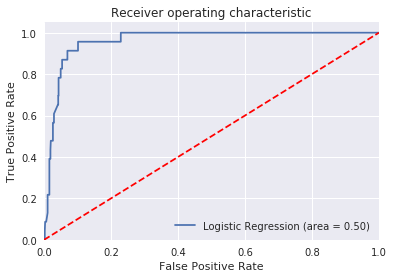

In [44]:
logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)

In [45]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred2 = rf.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

0.6039438042330472

In [46]:
conf2 = confusion_matrix(y_test, y_pred2)

In [47]:
conf2

array([[938,   9],
       [ 18,   5]])